In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imread
from skimage.transform import resize

In [2]:
# Directory paths
train_color_dir = os.path.join('data', 'train_color')
train_gray_dir = os.path.join('data', 'train_black')
test_color_dir = os.path.join('data', 'test_color')
test_gray_dir = os.path.join('data', 'test_black')

# Function to load and process images
def load_images(color_dir, gray_dir, target_size=(256, 256)):
    color_images = []
    gray_images = []

    # List and sort files
    color_files = sorted([f for f in os.listdir(color_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    gray_files = sorted([f for f in os.listdir(gray_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    common_files = set(color_files).intersection(set(gray_files))


    for file in common_files:
        try:
            color_image = imread(os.path.join(color_dir, file))
            gray_image = imread(os.path.join(gray_dir, file))

            # Ensure grayscale image has a single channel
            if gray_image.ndim == 3 and gray_image.shape[2] == 3:
                gray_image = rgb2gray(gray_image)  # Convert to grayscale if needed

        except Exception as e:
            print(f"Error loading file {file}: {e}")
            continue

        # Resize images
        color_image = resize(color_image, target_size)
        gray_image = resize(gray_image, target_size)

        # Convert to LAB for color images
        color_image_lab = rgb2lab(color_image)

        # Append processed images to lists
        color_images.append(color_image_lab)
        gray_images.append(gray_image)

    color_images = np.array(color_images)
    gray_images = np.array(gray_images).reshape(-1, target_size[0], target_size[1], 1)
    
    print("Loaded images:")
    print("Color images count:", len(color_images))
    print("Gray images count:", len(gray_images))
    
    return gray_images, color_images

# Load train and test images
X_train_gray, y_train_color = load_images(train_color_dir, train_gray_dir)
X_test_gray, y_test_color = load_images(test_color_dir, test_gray_dir)
print("Loading Complete")

# Extract the AB channels from the LAB images
y_train_ab = y_train_color[:, :, :, 1:] / 128
print("Extraction Step 1 Complete")

y_test_ab = y_test_color[:, :, :, 1:] / 128
print("Extraction Step 2 Complete")


Loaded images:
Color images count: 5000
Gray images count: 5000
Loaded images:
Color images count: 739
Gray images count: 739


In [3]:
# Check the shapes of the training and testing data
print("Shape of X_train_gray:", X_train_gray.shape)
print("Shape of y_train_ab:", y_train_ab.shape)
print("Shape of X_test_gray:", X_test_gray.shape)
print("Shape of y_test_ab:", y_test_ab.shape)

# Ensure the number of samples match
assert X_train_gray.shape[0] == y_train_ab.shape[0], "Mismatch in number of training samples"
assert X_test_gray.shape[0] == y_test_ab.shape[0], "Mismatch in number of testing samples"

Shape of X_train_gray: (5000, 256, 256, 1)
Shape of y_train_ab: (5000, 256, 256, 2)
Shape of X_test_gray: (739, 256, 256, 1)
Shape of y_test_ab: (739, 256, 256, 2)


In [4]:
# Define PSNR function
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

# U-Net Model Architecture
def unet_model(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    outputs = Conv2D(2, (1, 1), activation='tanh', padding='same')(conv7)

    model = Model(inputs, outputs)
    return model

In [5]:
model = unet_model()

# Compile and Train
model.compile(optimizer='adam', loss='mse', metrics=[psnr])

# Train the model using new datasets
model.fit(
    X_train_gray, y_train_ab,
    epochs=50,
    validation_data=(X_test_gray, y_test_ab),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate the Model
print("Evaluate on test data")
results = model.evaluate(X_test_gray, y_test_ab, batch_size=16)
print("Test loss, Test PSNR:", results)

# Visualize Predictions
predictions = model.predict(X_test_gray)

Epoch 1/50
  9/157 ━━━━━━━━━━━━━━━━━━━━ 2:03:33 50s/step - loss: 0.4159 - psnr: 4.4157

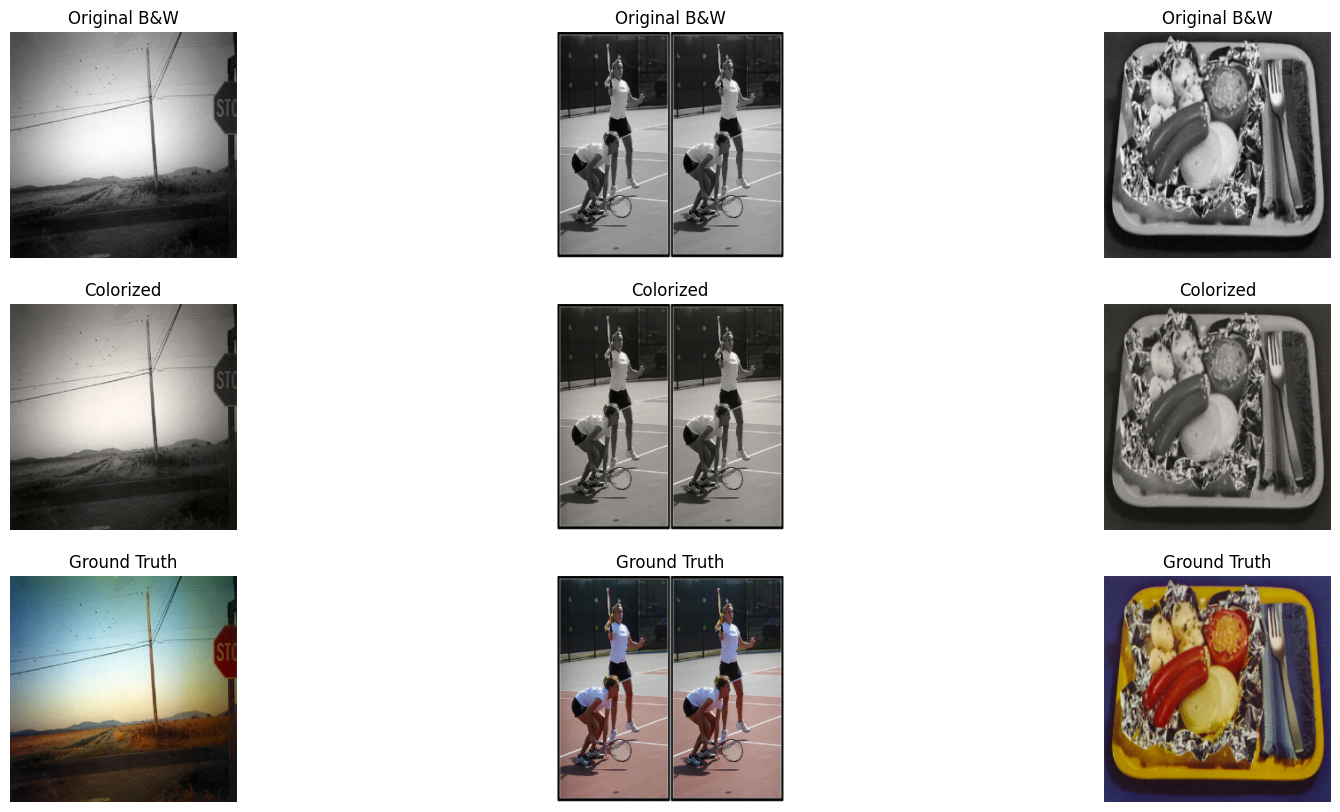

In [58]:
def ab_to_lab(ab_image, gray_image):
    # Ensure gray_image is properly shaped for LAB conversion
    gray_image = gray_image.reshape((256, 256, 1))
    
    # Rescale AB channels from [-1, 1] to [-128, 127]
    ab_image = ab_image * 128
    
    # Create LAB image
    lab_image = np.concatenate([gray_image * 100, ab_image], axis=-1)  # Gray is in [0, 100]
    
    # Ensure LAB image is within valid ranges
    lab_image[..., 1:] = np.clip(lab_image[..., 1:], a_min=-128, a_max=127)
    
    return lab_image
def check_shapes(lab_image):
    print("LAB Image Shape:", lab_image.shape)
    print("LAB Min Value:", np.min(lab_image))
    print("LAB Max Value:", np.max(lab_image))

def display_lab_channels(lab_image):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(lab_image[..., 0], cmap='gray')
    plt.title("L Channel")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(lab_image[..., 1], cmap='gray')
    plt.title("A Channel")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(lab_image[..., 2], cmap='gray')
    plt.title("B Channel")
    plt.axis("off")
    plt.show()
    
def display_results(bw_images, color_images, predictions, n=3):
    num_images = min(n, len(bw_images))
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Display original black and white image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(bw_images[i].reshape(256, 256), cmap='gray')
        plt.title("Original B&W")
        plt.axis("off")

        # Convert predictions to LAB and then to RGB
        lab_pred = ab_to_lab(predictions[i], bw_images[i].reshape(256, 256, 1))
        rgb_pred = lab2rgb(lab_pred)
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(rgb_pred)
        plt.title("Colorized")
        plt.axis("off")

        # Convert ground truth to LAB and then to RGB
        lab_true = ab_to_lab(color_images[i], bw_images[i].reshape(256, 256, 1))
        rgb_true = lab2rgb(lab_true)
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(rgb_true)
        plt.title("Ground Truth")
        plt.axis("off")

# Example usage
display_results(X_test_gray, y_test_ab, predictions)
